# ML Project Assignment - Samuele Ceol

## Classification task on Stroke Prediction Dataset

## Table of Contents
* [CHAPTER 0 - INTRODUCTION](#0)
    * [Section 0.1 - Project rationale & objective](#0.1)
    * [Section 0.2 - Dataset exploration](#0.2)
* [CHAPTER 1 - DATA CURATION](#1)
* [CHAPTER 2 - DEVELOPMENT OF A DECISION TREE ALGORITHM](#2)
* [CHAPTER 3 - TRAINING THE ALGORITHM](#3)
* [CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION](#4)
* [CHAPTER 5 - CONCLUSIONS](#5)

# CHAPTER 0 - INTRODUCTION <a class="anchor" id="0"></a>

## Section 0.1 - Project rationale & objective <a class="anchor" id="0.1"></a>

## Section 0.2 - Dataset exploration <a class="anchor" id="0.2"></a>

In [3]:
# This block contains all the libraries used in this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter

In [4]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

df.shape

(5110, 12)

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
print(df.gender.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.Residence_type.unique())
print(df.smoking_status.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [7]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

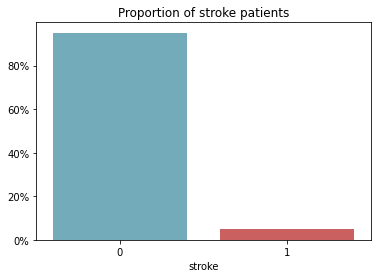

<Figure size 1440x720 with 0 Axes>

In [8]:
def stroke_proportion(curr_df, title):
    g = sns.barplot(
        x='stroke',
        y='stroke',  
        alpha=.75,
        palette=['#3697b5', '#d11313'],
        edgecolor='black',
        linewidth=0,
        data=curr_df,
        estimator=lambda x: len(x) / len(curr_df) * 100
    )
    
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    g.set_ylabel('')

    plt.title(title)
    plt.figure(figsize=(20, 10))

stroke_proportion(df, "Proportion of stroke patients")

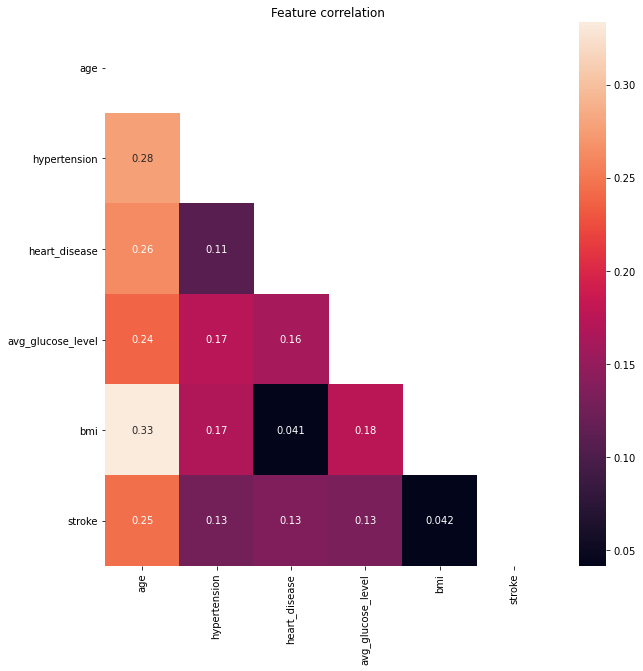

In [9]:
plt.figure(figsize=(10, 10))
plt.title('Feature correlation')

df_corr = df.drop(['id'], axis=1).corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df_corr, 
    linecolor='black', 
    mask=mask,
    annot=True)
plt.show()

In [10]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

In [11]:
#Since the data is unbalanced, divide it for representation purposes
stroke_df = df[df['stroke'] == 1]
no_stroke_df = df[df['stroke'] == 0]

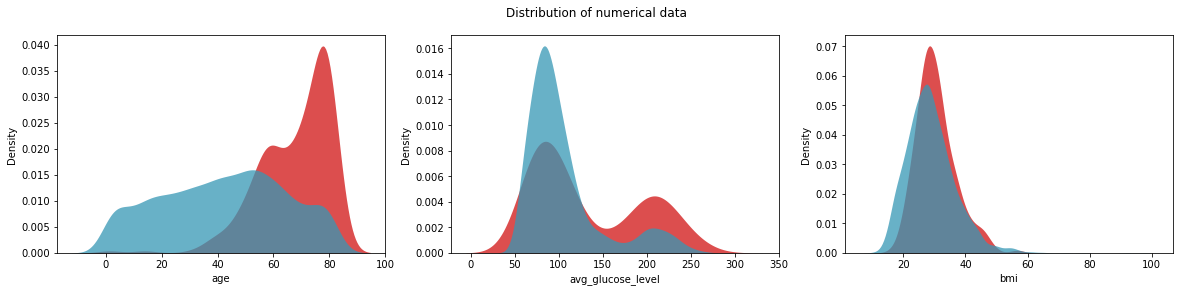

In [12]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
subplot = 131

fig = plt.figure(figsize=(20, 4))

for i in numeric_features:
    plt.subplot(subplot)

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#d11313',
        shade=True,
        linewidth=0,
        data=stroke_df
    )

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#3697b5',
        shade=True,
        linewidth=0,
        data=no_stroke_df
    )

    subplot += 1

plt.suptitle('Distribution of numerical data')
plt.show()

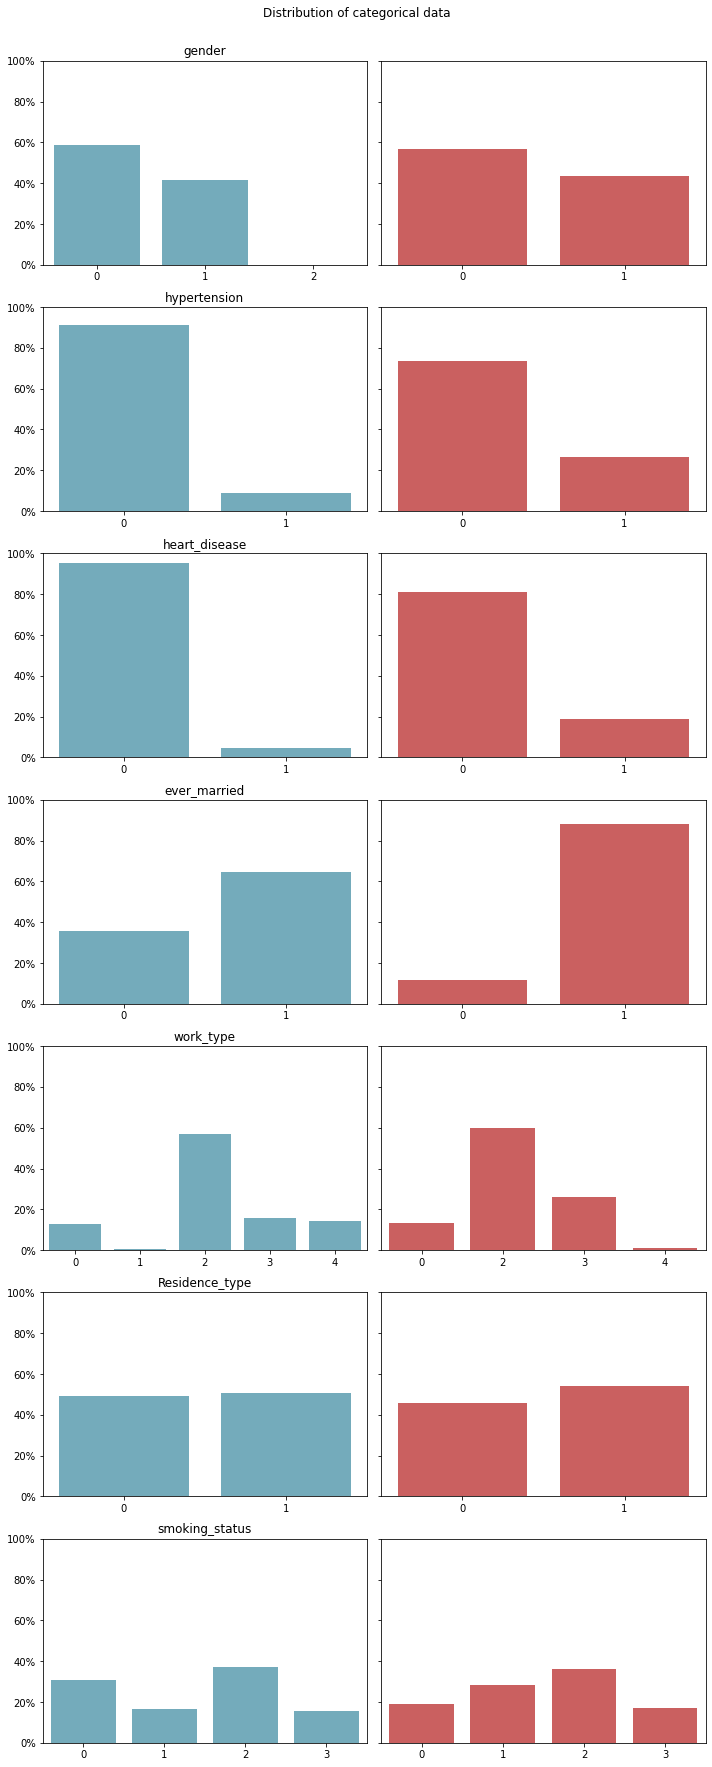

In [13]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 25), sharey=True)

for i in range(len(categorical_features)):
    feature = categorical_features[i]

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#3697b5',
        data=no_stroke_df, 
        estimator=lambda x: len(x) / len(no_stroke_df) * 100,
        ax=ax[i,0]
    )

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#d11313', 
        data=stroke_df, 
        estimator=lambda x: len(x) / len(stroke_df) * 100,
        ax=ax[i,1]
    )

    ax[i,0].set_title(feature)
    ax[i,0].set_ylabel('')
    ax[i,1].set_ylabel('')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Distribution of categorical data')
plt.show()

# CHAPTER 1 - DATA CURATION <a class="anchor" id="1"></a>

In [14]:
## Removing ids
df = df.drop(['id'], axis=1)

In [15]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

In [16]:
## Handling NaN values
#TODO - For now remove
df.dropna(subset = ['bmi'], inplace=True)

## Handling unbalanced data (oversampling with SMOTE)

Synthesizing (training set) entries for the minority class with SMOTE

Shape before SMOTE: (3436, 10)
Shape after SMOTE: (6598, 10)


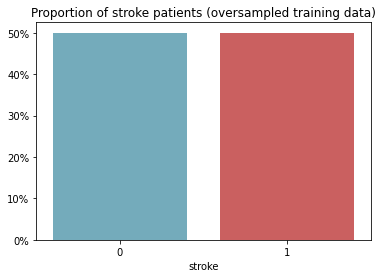

<Figure size 1440x720 with 0 Axes>

In [17]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oversample = SMOTE()
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

oversampled_df = X_train_SMOTE.assign(stroke = y_train_SMOTE)
stroke_proportion(y_train_SMOTE, "Proportion of stroke patients (oversampled training data)")
print("Shape before SMOTE: " + str(X_train.shape))
print("Shape after SMOTE: " + str(X_train_SMOTE.shape))

# CHAPTER 2 - DEVELOPMENT OF A DECISION TREE ALGORITHM <a class="anchor" id="2"></a>

In [95]:
def calc_gini(class_occ, size_part):
    return 1 - sum((class_occ[curr_class]/size_part)**2 for curr_class in class_occ)

def gini_index(X,y):
    # Calculate the occurences of each class in the partition
    class_occ_part = Counter(y)

    # Calculate Gini Index of the current partition
    size_part = y.size
    idx_part = calc_gini(class_occ_part, size_part)

    # TODO
    idx_delta = 0 

    # Loop through all features
    for feature in X:
        # Sort the examples in increasing order for the selected feature
        # Consider the midpoint between two (different) adjecent values as a possible split point
        feature_val, class_val = zip(*sorted(zip(X[feature].values.flatten(), y), key=lambda x: x[0]))

        # Go through the sorted feature while keeping track of class occurences on each side (/partition)
        class_occ_left = Counter({0:0, 1:0}) # TODO - Improve this
        class_occ_right = class_occ.copy() # Same as occurences of each class in the partition

        for example in range(1,y.size):
            example_class = y[example-1]

            # Incremßent the example class on the left, decrement it on the right
            # Calculate the Gini index for each side
            class_occ_left[example_class] += 1
            size_left = example
            idx_left = calc_gini(class_occ_left, size_left)

            class_occ_right[example_class] -= 1
            size_right = y.size - example
            idx_right = calc_gini(class_occ_right, size_right)

            # Skip ahead if two adjacent values are equal
            # TODO
            
            # Calculate the final Gini index value (split with selected feature at current example)
            idx_feature_example = ((size_left/size_part) * idx_left) + ((size_right/size_part) * idx_right)

            # TODO - Calculate the reduction in inpurity with the current split
            curr_idx_delta = idx_part - idx_feature_example
            if(curr_idx_delta > idx_delta):
                idx_delta = curr_idx_delta
                idx_feature = feature
                idx_example = example

    print(idx_delta)
    print(idx_feature)
    print(idx_example)


In [96]:
gini_index(X_train_SMOTE,y_train_SMOTE.values.flatten())

0.460128055878929
gender
3436


In [94]:
Counter(X_train_SMOTE['gender'])

Counter({0: 4503, 1: 2094, 2: 1})

# CHAPTER 3 - TRAINING THE ALGORITHM <a class="anchor" id="3"></a>

# CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION <a class="anchor" id="4"></a>

In [20]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
print(cross_val_score(clf,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1').mean())

0.9189361895152798


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
rf_cv = cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1').mean())

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataCo

# CHAPTER 5 - CONCLUSIONS <a class="anchor" id="5"></a>